In [2]:
import torch
import numpy as np
import scipy
#packages
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os

import numpy as np
#from torchdyn.numerics import odeint
from torchdiffeq import odeint
from icecream import ic
from tqdm import tqdm
import scipy
from itertools import chain
import cProfile
import pstats
from get_data import get_batch, get_data, get_batch_RNN

In [8]:

def input(t, u_option):
  
  if u_option=="noise":
   return np.random.normal(0, 0.2, len(t))
  
  if u_option=="sin":
   return 0.1 * np.sin(t)
  
  if u_option=="cos":
   return np.cos(t)
  

  else: 
   return 0
  

def func(y,t, u):
  f = 1
  #0.5
  
  return np.array([y[1], 1/f*(-np.sin(y[0])- 1/7*y[1] + u )])


In [9]:
t =np.linspace(0,30,20)
steps = np.random.uniform(-0.02, 0.02, len(t))
steps[0] = np.random.uniform(-0.2, 0.2, 1)
walk = np.cumsum(steps)
walk


#0.1 * np.sin(t)

C:\Users\strasserp\AppData\Local\Temp\ipykernel_14120\2272853021.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  steps[0] = np.random.uniform(-0.2, 0.2, 1)


array([ 0.        ,  0.09999668, -0.00163014, -0.0999701 ,  0.00325984,
        0.09991696, -0.00488868, -0.09983727,  0.00651621,  0.09973104,
       -0.00814202, -0.09959831,  0.00976566,  0.09943911, -0.01138671,
       -0.09925349,  0.01300473,  0.09904148, -0.01461929, -0.09880316])

In [9]:
a = func(np.array([1, 0.1]), t=5 ,args="noise")
b = func(a, t=5 ,args="noise")
a,b

TypeError: func() got an unexpected keyword argument 'args'

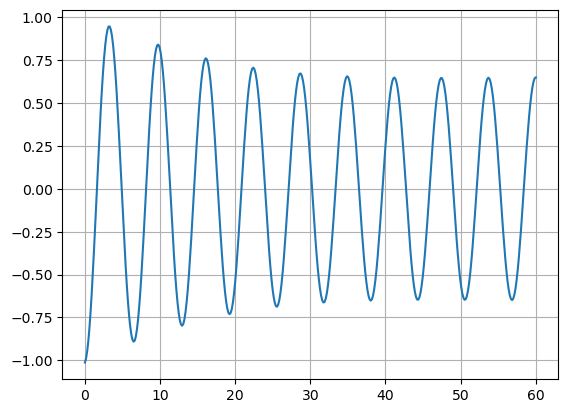

In [13]:

n=400

t = np.linspace(0, 60, n)

u_option = "sin"
#
for j in range(1):
    y0_list_w = np.random.uniform(-np.pi/3, np.pi/3, size=(1, 1))
    y0_list_o = np.random.uniform(-0.1, 0.1, size=(1, 1))
    y0_list = np.concatenate([y0_list_w, y0_list_o], axis=1)

    z0 = y0_list[0]
    u = input(t, u_option)

    #u = np.sin(3*t)/2
    #u = (t**2 - 2*t)*0.0001

    # 
    out = np.zeros((len(t), 2))
    out[0] = z0

    for i in range(1, n):
        t_span = [t[i-1], t[i]]
        z = scipy.integrate.odeint(func, out[i-1], t_span, args = (u[i],))
        out[i] = z[1]

    plt.plot(t,out[:,0])
plt.grid()
plt.show()

In [14]:
input_data, test_data, time, initial_values = generate_data(x0 = np.pi/4, y0 = 0.1, use_fixed_init = False, t0=0, t1=60, 
                                           time_steps=200, num_of_inits=10, normalize=True, add_noise=False, u_option="noise")

ic(input_data.size())
ic(test_data.size())

NameError: name 'generate_data' is not defined

In [ ]:
for x in input_data:
    plt.plot(time, x[:,2])

plt.show()

In [ ]:
train_size = int(0.8 * len(input_data))
test_size = len(input_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input_data, [train_size, test_size])

ic(train_dataset)
for x in train_dataset:
    ic(x)

In [15]:

def get_data(x0 = np.pi/4, y0 = 0.1, use_fixed_init = False, t0=0, t1=30, time_steps=1000, num_of_inits=1, normalize=True, add_noise=False, u_option="noise"):

    np.random.seed(seed=42)

    
    y0 = [x0, y0]
    
    t = np.linspace(t0, t1,num=time_steps)
    y0_list_w = np.random.uniform(-np.pi/1, np.pi/1, size=(num_of_inits, 1)) 
    y0_list_o = np.random.uniform(-0.2, 0.2, size=(num_of_inits, 1)) 
    y0_list = np.concatenate([y0_list_w, y0_list_o], axis=1)
    
    if use_fixed_init:
      y0_list = [y0]
      
    trajectory_list = []
    input_data_list = []
    input_data_w_time_list = []

    for i, y0 in enumerate(y0_list):

      np.random.seed(seed=i)
      
      out = np.zeros((len(t), 2))
     
      out[0] = y0_list[i]
      
      u = input(t, u_option)
     
      for i in range(1, len(t)):

        t_span = [t[i-1], t[i]]
        z = scipy.integrate.odeint(func, out[i-1], t_span, args = (u[i],))

        out[i] = z[1]

      out = torch.tensor(out)
      u = torch.tensor(u).view(1,len(t))
      u = u.transpose(0,1)
      time = torch.tensor(t)
      time = time.view(1,len(t))
      time = time.transpose(0,1)

      trajectory_list.append(out)
      input_data_list.append(torch.cat((u,out), dim=-1))
      input_data_w_time_list.append(torch.cat((time,u,out), dim=-1))

    test_data = torch.stack(trajectory_list)
    input_data = torch.stack(input_data_list)

    input_data_w_time = torch.stack(input_data_w_time_list)

    if normalize:
      
     test_data = torch.nn.functional.normalize(test_data) 
     input_data = torch.nn.functional.normalize(input_data) 
     input_data_w_time = torch.nn.functional.normalize(input_data_w_time) 
    #  test_data = test_data/torch.max(abs(test_data))
    #  input_data = input_data/torch.max(abs(input_data))
    #  input_data_w_time = input_data_w_time/torch.max(abs(input_data_w_time))

     
    return input_data, test_data, time, torch.tensor(y0_list), input_data_w_time



In [40]:
window_size = 1
start_time = 0
stop_time = 10
timesteps = 15
num_of_inits = 3
option_odestep = True
losses=[]

input_data, test_data, time, initial_values, input_data_w_time = get_data(x0 = np.pi/4, y0 = 0.1, use_fixed_init = False, t0=start_time, t1=stop_time, 
                                                                                time_steps=timesteps, num_of_inits=num_of_inits, normalize=False, add_noise=False, u_option="noise")


train_size = int(0.8 * len(input_data))
test_size = len(input_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input_data, [train_size, test_size])

In [42]:
train_dataset[:][:,0:8, :]

tensor([[[-0.0834,  1.4577, -0.1376],
         [-0.0113,  1.1197, -0.7872],
         [-0.4272,  0.2925, -1.4451],
         [ 0.3281, -0.5995, -0.9575],
         [-0.3587, -1.1612, -0.5800],
         [-0.1683, -1.3618,  0.0149],
         [ 0.1006, -1.0887,  0.7272],
         [-0.2491, -0.4660,  0.9602]],

        [[ 0.3249,  2.8319, -0.1376],
         [-0.1224,  2.6213, -0.4695],
         [-0.1056,  2.1265, -0.9505],
         [-0.2146,  1.1966, -1.6535],
         [ 0.1731, -0.0504, -1.7165],
         [-0.4603, -1.2249, -1.4681],
         [ 0.3490, -1.8934, -0.4234],
         [-0.1522, -1.9903,  0.1381]]], dtype=torch.float64)

In [ ]:
torch.manual_seed(3)
a = torch.rand(20, 100, 2)*15
b = torch.rand(20, 100, 2)*6
a=a-b
ic(a.size(dim=1))
#a = a/torch.max(abs(a))

a = torch.nn.functional.normalize(a)
#ic(a)
for i in range(20):
    print(np.linalg.norm(a[i,:,0].numpy()), torch.mean(a[i,:,0]))
